In [77]:
import bolift
import pandas as pd
import numpy as np
import cloudpickle

In [268]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (5.0, 5.0 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# RF baseline

## Experiment outputs

In [ ]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-6]
features, labels


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )

    X_train, y_train = train
    X_test, y_test = test
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

models = {}
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(train_df.keys())

for i, k in enumerate(labels):
    # print(k, i, labels[i])
    train = (train_df[features], train_df[labels[i]])
    test = (test_df[features], test_df[labels[i]])
    models[k] = train_model(train, test)

    

In [ ]:
k = 0
sample = test_df.iloc[k:k+1]
feats = sample[features]
labs = sample[labels]

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

for k in labels:
    # print(k, rmse(models[k].predict(feats), labs[k].values))
    print(k, models[k].predict(feats), labs[k].values)

w = [float(a) for a in sample.iloc[0]['Fl_Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample.iloc[0]['Fluorescence_norm'][1:-1].split(',')]

# plt.figure(figsize=(6, 4))
plt.plot(w, i, color="C0", label="Reference")
# plt.title(f"{sample.iloc[0]['Experiment']}: {sample.iloc[0]['Temperature(C)']}°C, {sample.iloc[0]['Doping(%)']}%, {sample.iloc[0]['Time(min)']}min")
plt.title(f"XGBoost Model Prediction: Spectra Metrics")
plt.axvline(x = models['Peak1'].predict(sample[features]), color = 'C1', linestyle = '--', label = 'Peak1')
plt.axvline(x = models['Peak2'].predict(sample[features]), color = 'C3', linestyle = '--', label = 'Peak2')
# change plt figsize
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized fluorescence (a.u.)")
plt.tight_layout()
plt.legend()
plt.show()

## Spectra output

In [ ]:
df = pd.read_csv('Data/fl_spectra_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = list(df.keys()[:index]) + ['Wavelength(nm)']
labels = ['Fluorescence_norm']
features, labels

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )
    
    X_train, y_train = train[train.columns.difference(['Fluorescence', 'Fluorescence_norm'])], train['Fluorescence_norm']
    X_test, y_test = test[test.columns.difference(['Fluorescence', 'Fluorescence_norm'])], test['Fluorescence_norm']
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

def test_model(model, validation):
    val_feats = validation[validation.columns.difference(['Fluorescence', 'Fluorescence_norm'])]
    val_labels = validation["Fluorescence_norm"]

    pred = model.predict(val_feats)
    return (pred, val_labels.to_numpy(), val_feats['Wavelength(nm)'].to_numpy())

In [23]:
from sklearn.model_selection import train_test_split

one_out = []
i=0
for group, validation in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    data = df.copy()
    exp, T, d, t = group
    validation = validation[features + labels]

    # validation = data.query(
    #     f'`Temperature(C)` == {T} & `Doping(%)` == {d} & `Time` == {t}'
    # )
    train_df = data.drop(validation.index)
    train, test = train_test_split(train_df[features + labels], test_size=0.2, random_state=42)

    model = train_model(train, test)

    prediction = test_model(model, validation)
    one_out.append((group, prediction))


KeyError: 'Experiment'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i=0
for group, predictions in one_out:
    axs = axs.flatten()
    exp, T, d, t = group
    if exp not in ["8_NPL-13_(3-8-23)", "7_NPL-12_(3-8-23)"] or T != 0.0 or t != 60:
        continue
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    title = f"Doping: {d}%"

    if i == 0:
        axs[i].plot(predictions[2], predictions[0], color="C0", label='Prediction')
        axs[i].plot(predictions[2], predictions[1], color="C1", label='labels')
    else:
        axs[i].plot(predictions[2], predictions[0], color="C0")
        axs[i].plot(predictions[2], predictions[1], color="C1")
    axs[i].set_title(title)

    i+=1 
    # plt.savefig(f'preds/{group}.png')
fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
fig.suptitle(f"7_NPL-12_(3-8-23) and 8_NPL-13_(3-8-23): T: 25 ºC, Time: 60 min")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

i=0
for group, predictions in one_out:
    if i == 0:
        exp, T, d, t = group
        title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
        plt.figure()
        sns.lineplot(x=predictions[2], y=predictions[1], label='Reference')
        sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction')
        plt.legend()
        # plt.savefig(f'preds/{group}.png')
        fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
        # plt.title(title)
        plt.title("XGBoost Model Prediction: Entire Spectra")
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Normalized fluorescence (a.u.)")
        plt.tight_layout()
        plt.show()
    i += 1



### Evaluate predictions

In [13]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [ ]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

pred_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}
label_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}

for group, predictions in one_out:
    pred_peak = get_peaks(predictions[2], predictions[0])
    pred_norm_area = get_area_under_peaks(predictions[2], predictions[0])
    pred_area = get_area_under_peaks(predictions[2], predictions[0], norm=pred_norm_area)

    label_peak = get_peaks(predictions[2], predictions[1])
    label_norm_area = get_area_under_peaks(predictions[2], predictions[1])
    label_area = get_area_under_peaks(predictions[2], predictions[1], norm=label_norm_area)
    
    pred_dict["Peak1"].append(pred_peak[0])
    pred_dict["Peak2"].append(pred_peak[1])
    pred_dict["Area1"].append(pred_area[0])
    pred_dict["Area2"].append(pred_area[1])
    pred_dict["Distance_peaks"].append(pred_peak[1] - pred_peak[0])

    label_dict["Peak1"].append(label_peak[0])
    label_dict["Peak2"].append(label_peak[1])
    label_dict["Area1"].append(label_area[0])
    label_dict["Area2"].append(label_area[1])
    label_dict["Distance_peaks"].append(label_peak[1] - label_peak[0])
    
    #plot
    # exp, T, d, t = group
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    # plt.figure()
    # sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction').set(title=title)
    # sns.lineplot(x=predictions[2], y=predictions[1], label='label')
    # plt.legend()
    # plt.show()    

for k in pred_dict.keys():
    print(k, rmse(np.array(pred_dict[k]), np.array(label_dict[k])))

# bolift

In [314]:
import os
import cloudpickle
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [328]:
df = pd.read_csv('Data/procedures.tsv', sep="\t")
df = df[df['QY'] > 0]

import numpy as np
indexes = np.arange(len(df))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

# plt.set_cmap('Dark2')
# train_df = df.iloc[indexes[:int(split*len(indexes))]]
# test_df = df.iloc[indexes[int(split*len(indexes)):]]
# train_indexes = train_df.index
# test_indexes = test_df.index

plt.set_cmap('viridis')
train_df = df[~df['Experiment'].str.startswith('M5') & ~df['Experiment'].str.startswith('M6')]
test_df = df[df['Experiment'].str.startswith('M5') | df['Experiment'].str.startswith('M6')]
train_indexes = train_df.index
test_indexes = test_df.index


with open('Data/system_message.txt', 'r') as f:
    system_message = f.read()

<Figure size 500x416.667 with 0 Axes>

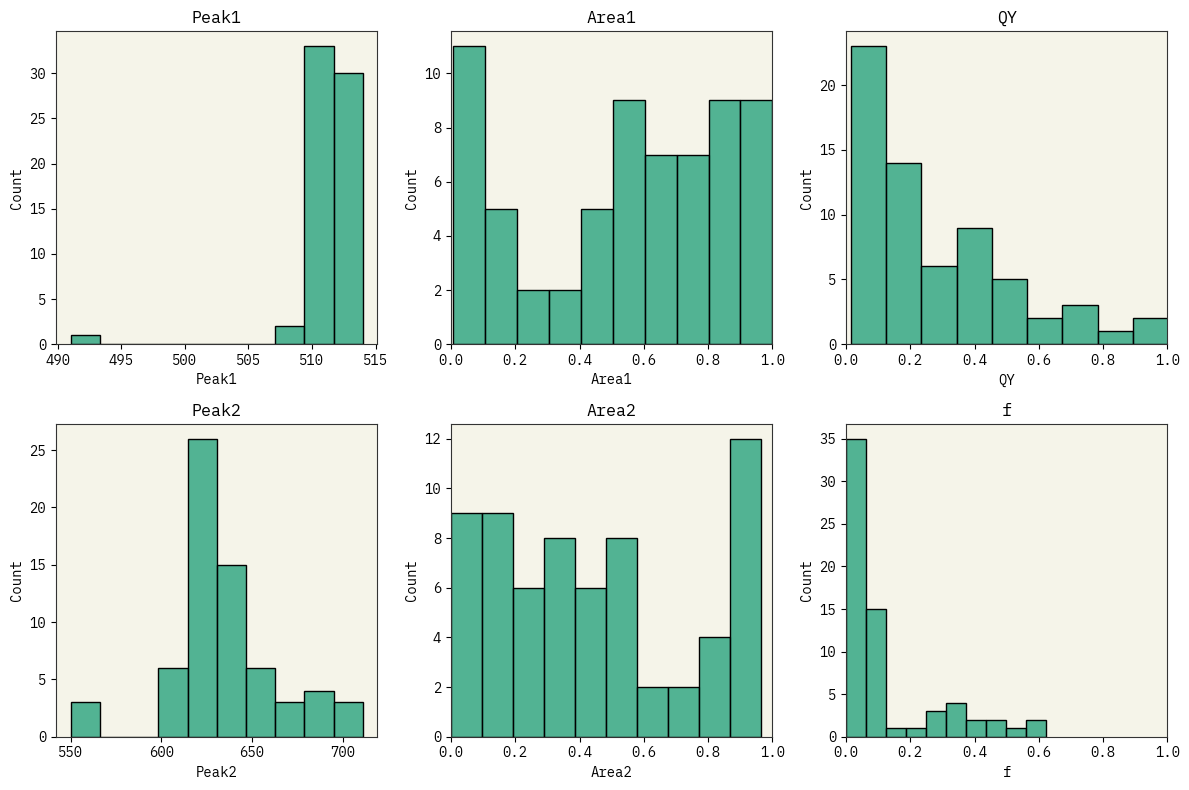

In [329]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, k in enumerate(['Peak1', 'Area1', 'QY','Peak2', 'Area2', 'f']):
    sns.histplot(train_df[k], ax=axs[i], bins=10, color='C0')
    axs[i].set_title(k)
    if k not in ["Peak1", "Peak2"]:
        axs[i].set_xlim(0, 1)
plt.tight_layout()
plt.show()


## Predicting peaks

In [327]:
asktell_peak1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell_peak2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_peak1.tell(df['Prompt'][i], df['Peak1'][i])

for i in train_indexes:
    asktell_peak2.tell(df['Prompt'][i], df['Peak2'][i])

KeyboardInterrupt: 

In [196]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
yhat_2=[]
y_1=[]
y_2=[]
for i in test_indexes:
  yhat_1.append(asktell_peak1.predict(df['Prompt'][i], system_message=system_message))
  yhat_2.append(asktell_peak2.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(df['Peak1'][i])
  y_2.append(df['Peak2'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['Peak1'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {df['Peak2'][i]}")


504.00+/-10.62 : 512.0 // 668.20+/-23.74 : 703.0
511.00+/-2.93 : 512.0 // 642.20+/-10.85 : 674.0
512.20+/-2.64 : 508.0 // 622.80+/-10.81 : 658.0
507.80+/-0.40 : 508.0 // 588.00+/-10.71 : 638.0
510.00+/-1.26 : 512.0 // 662.80+/-19.95 : 710.0
512.00+/-2.93 : 512.0 // 399.21+/-312.15 : 682.0
508.40+/-1.62 : 509.0 // 600.00+/-36.36 : 677.0
508.40+/-1.62 : 549.0 // 577.20+/-20.51 : 710.0
512.00+/-2.93 : 512.0 // 677.20+/-15.55 : 671.0
508.40+/-1.20 : 512.0 // 668.20+/-15.08 : 686.0
511.00+/-2.93 : 512.0 // 631.80+/-29.25 : 677.0
505.80+/-7.93 : 508.0 // 621.40+/-18.68 : 660.0
508.80+/-1.47 : 508.0 // 496.60+/-224.17 : 643.0
509.00+/-2.10 : 512.0 // 632.00+/-7.29 : 675.0
512.00+/-2.93 : 512.0 // 653.80+/-13.38 : 678.0
508.00+/-1.10 : 508.0 // 614.20+/-13.23 : 675.0
507.60+/-1.62 : 512.0 // 588.80+/-26.19 : 704.0
512.00+/-2.93 : 512.0 // 678.60+/-13.29 : 682.0


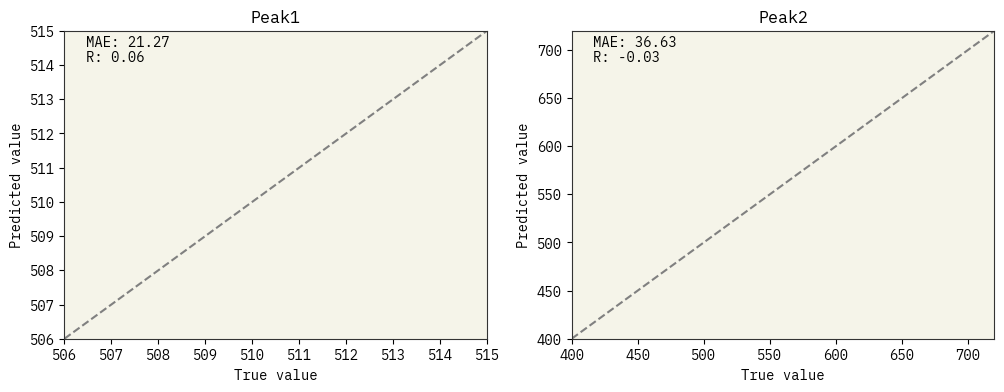

In [197]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("Peak1")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs[0])
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs[0].transAxes)
# get the min and max in axis y
axs[0].set_xlim(506, 515)
axs[0].set_ylim(506, 515)


axs[1].set_title("Peak2")
sns.scatterplot(x=y_2, y=[yi.mean() for yi in yhat_2], ax=axs[1])
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(y_2), np.array([yi.mean() for yi in yhat_2])):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_2, [yi.mean() for yi in yhat_2])[0, 1]:.2f}", transform=axs[1].transAxes)
axs[1].set_xlim(600, 720)
axs[1].set_ylim(600, 720)

plt.show()

In [198]:
# i=0
# for group, predictions in one_out:
#     if i == 0:
#         exp, T, d, t = group
#         title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
#         plt.figure()
#         sns.lineplot(x=predictions[2], y=predictions[1], label='Reference')
#         plt.axvline(x = asktell1.predict(prompts[0]).mean(), color = 'C1', linestyle = '--', label = 'Peak1')
#         plt.axvline(x = asktell2.predict(prompts[0]).mean(), color = 'C3', linestyle = '--', label = 'Peak2')
#         fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
#         # plt.title(title)
#         plt.title("LLM Prediction: Spectra Metrics")
#         plt.legend()
#         plt.xlabel("Wavelength (nm)")
#         plt.ylabel("Normalized fluorescence (a.u.)")
#         plt.tight_layout()
#         plt.show()
#     i += 1

## Predicting areas

In [330]:
asktell_auc1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="area under the first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell_auc2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="area under the second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_auc1.tell(df['Prompt'][i], df['Area1'][i])

for i in train_indexes:
    asktell_auc2.tell(df['Prompt'][i], df['Area2'][i])

In [331]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
yhat_2=[]
y_1=[]
y_2=[]
for i in test_indexes:
  yhat_1.append(asktell_auc1.predict(df['Prompt'][i], system_message=system_message))
  yhat_2.append(asktell_auc2.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(df['Area1'][i])
  y_2.append(df['Area2'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['Area1'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {df['Area2'][i]}")


0.27+/-0.03 : 0.0159319452142701 // 0.68+/-0.06 : 0.907779872634646
0.55+/-0.16 : 0.2913299064067982 // 0.65+/-0.24 : 0.6885024396086137
0.31+/-0.09 : 0.3337016146713414 // 0.47+/-0.15 : 0.6590716491873605
0.53+/-0.17 : 0.6909245344307962 // 0.39+/-0.13 : 0.308120226065005
0.56+/-0.29 : 0.0401353753129296 // 0.63+/-0.13 : 0.8662336968256829
0.43+/-0.05 : 0.0776890168951515 // 0.65+/-0.21 : 0.8924789752206166
0.32+/-0.17 : 0.0354377223146335 // 0.69+/-0.08 : 0.9440783841615122
0.73+/-0.08 : 0.0059065831486889 // 0.54+/-0.08 : 0.9144309708802528
0.43+/-0.32 : 0.3233131794115474 // 0.87+/-0.01 : 0.6602438162860779
0.32+/-0.05 : 0.0148543538163129 // 0.72+/-0.06 : 0.9687313694156364
0.58+/-0.14 : 0.2490210867709846 // 0.70+/-0.27 : 0.7348353201818786
0.30+/-0.02 : 0.2756405406363365 // 0.41+/-0.11 : 0.7184085233104437
0.64+/-0.15 : 0.6621421362243245 // 0.33+/-0.01 : 0.3367027850028067
0.71+/-0.34 : 0.0329321133568393 // 0.63+/-0.13 : 0.9578560032652306
0.40+/-0.07 : 0.2953745724010526 // 

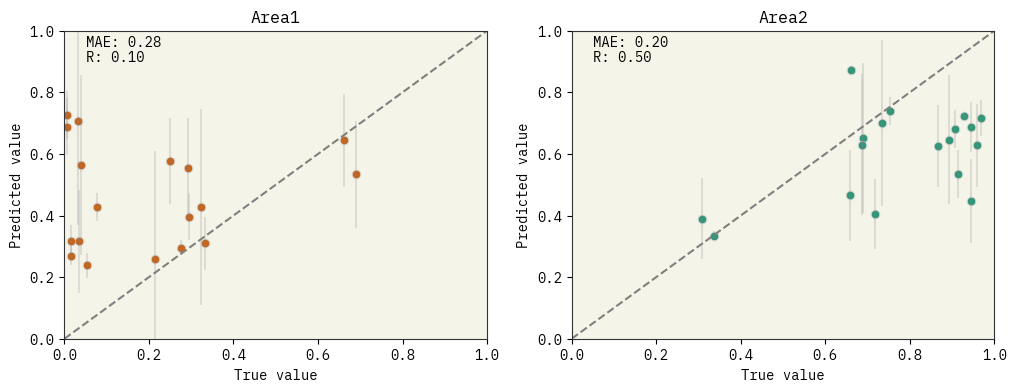

In [332]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("Area1")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs[0], color='C1')
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs[0].transAxes)
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)

axs[1].set_title("Area2")
sns.scatterplot(x=y_2, y=[yi.mean() for yi in yhat_2], ax=axs[1], color='C0')
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(y_2), np.array([yi.mean() for yi in yhat_2])):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_2, [yi.mean() for yi in yhat_2])[0, 1]:.2f}", transform=axs[1].transAxes)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

plt.show()

## Predicting QY

In [333]:
asktell_qy = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="quantum yield",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_qy.tell(df['Prompt'][i], df['QY'][i])

In [334]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
y_1=[]
for i in test_indexes:
  yhat_1.append(asktell_qy.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(df['QY'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['QY'][i]}")


0.40+/-0.16 : 0.2190160286367103
0.61+/-0.08 : 0.2322909137834386
0.57+/-0.12 : 0.2019371414348416
0.80+/-0.13 : 0.356291044678331
0.63+/-0.02 : 0.0985666278540419
0.54+/-0.18 : 0.3428275218177215
0.88+/-0.12 : 0.1647361191079822
0.51+/-0.12 : 0.2296859892610654
0.46+/-0.11 : 0.4108655328431772
0.51+/-0.11 : 0.1325067075802836
0.74+/-0.13 : 0.226241905079054
0.65+/-0.03 : 0.1955621490072093
0.39+/-0.23 : 0.11140614793558
0.81+/-0.14 : 0.1342080747928236
0.55+/-0.12 : 0.2372580569518164
0.95+/-0.03 : 0.173928621769507
0.56+/-0.18 : 0.1984103445544227
0.58+/-0.06 : 0.2259778486882372


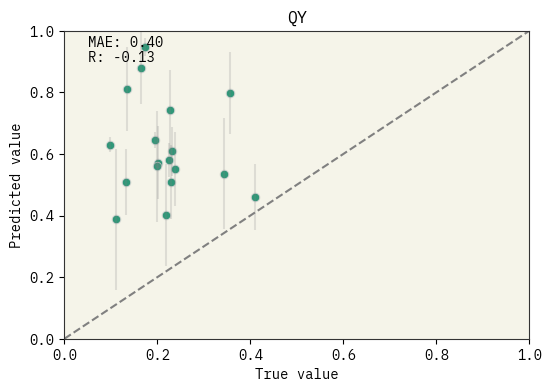

In [335]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs.set_title("QY")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs, color='C0')
axs.set_xlabel("True value")
axs.set_ylabel("Predicted value")
axs.plot([0, 1], [0, 1], transform=axs.transAxes, ls="--", color="gray")
axs.errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs.text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs.transAxes)
axs.text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs.transAxes)
axs.set_xlim(0, 1)
axs.set_ylim(0, 1)

plt.show()

## Predicting f=QY*AUC2

In [336]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell.tell(df['Prompt'][i], df['f'][i])

In [337]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
y_1=[]
for i in test_indexes:
  yhat_1.append(asktell.predict(df['Prompt'][i], system_message=system_message))
  y_1.append(df['f'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['f'][i]}")


0.34+/-0.14 : 0.1988183425807789
0.30+/-0.18 : 0.1599328608388116
0.30+/-0.17 : 0.1330910448376423
0.17+/-0.06 : 0.1097804772312241
0.25+/-0.04 : 0.0853817344296481
0.50+/-0.22 : 0.3059663553493036
0.26+/-0.28 : 0.1555238091405023
0.14+/-0.06 : 0.2100319821575873
0.56+/-0.18 : 0.2712714273847921
0.24+/-0.04 : 0.1283634042910054
0.30+/-0.21 : 0.1662505427573248
0.28+/-0.09 : 0.1404935146836862
0.21+/-0.05 : 0.0375107602763444
0.21+/-0.07 : 0.1285520101269751
0.46+/-0.24 : 0.1630117208364813
0.24+/-0.21 : 0.1613264409922826
0.24+/-0.11 : 0.1876191624268434
0.68+/-0.20 : 0.1702781335879201


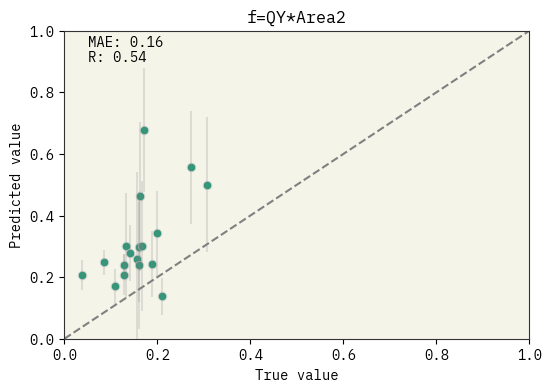

In [348]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs.set_title("f=QY*Area2")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs, color='C0')
axs.set_xlabel("True value")
axs.set_ylabel("Predicted value")
axs.plot([0, 1], [0, 1], transform=axs.transAxes, ls="--", color="gray")
axs.errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs.text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs.transAxes)
axs.text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs.transAxes)
axs.set_xlim(0, 1)
axs.set_ylim(0, 1)
plt.show()

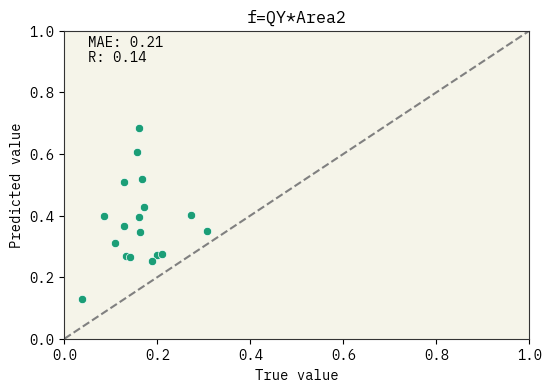

In [347]:
auc = np.array([0.68, 0.65, 0.47, 0.39, 0.63, 0.65, 0.69, 0.54, 0.87, 0.72, 0.70, 0.41, 0.33, 0.63, 0.63, 0.72, 0.45, 0.74])
p = np.array([0.40, 0.61, 0.57, 0.80, 0.63, 0.54, 0.88, 0.51, 0.46, 0.51, 0.74, 0.65, 0.39, 0.81, 0.55, 0.95, 0.56, 0.58])
y_pred = auc*p

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
axs.set_title("f=QY*Area2")
sns.scatterplot(x=y_1, y=y_pred, ax=axs, color='C0')
axs.set_xlabel("True value")
axs.set_ylabel("Predicted value")
axs.plot([0, 1], [0, 1], transform=axs.transAxes, ls="--", color="gray")
axs.text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array(y_pred)):.2f}", transform=axs.transAxes)
axs.text(0.05, 0.90, f"R: {np.corrcoef(y_1, y_pred)[0, 1]:.2f}", transform=axs.transAxes)
axs.set_xlim(0, 1)
axs.set_ylim(0, 1)
plt.show()


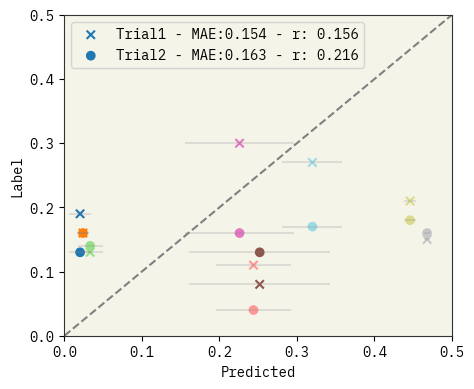

In [352]:
'''
Trial |             f = QY*AUC2                         |
        |  rep1 |   rep2| Predicted/designed |
1.    | 0.19  | 0.13 | 0.02024 +/- 0.01381|
2.    | 0.16  | 0.16 |  0.024 +/- 0.008.     |
3.    | 0.13  | 0.14 | 0.03320 +/- 0.0162 |
4.    | 0.11  | 0.04 |. 0.244 +/- 0.0484     |
5.    | 0.08  | 0.13 | 0.252 +/- 0.09130    |
6     | 0.30  | 0.16 |. 0.226 +/- 0.07          |
7.    | 0.15  | 0.16 |. 0.468 +/- 0.00399   |
8.    | 0.21  | 0.18 | 0.4460 +/- 0.008      |
9     | 0.27  | 0.17. | 0.32 +/- 0.0388         |
'''

t1 = np.array([
    0.19, 0.16, 0.13, 0.11, 0.08, 0.30, 0.15, 0.21, 0.27
])
t2 = np.array([
    0.13, 0.16, 0.14, 0.04, 0.13, 0.16, 0.16, 0.18, 0.17
])
predicted = np.array([
    0.02024, 0.024, 0.03320, 0.244, 0.252, 0.226, 0.468, 0.446, 0.32
])
std = np.array([
    0.01381, 0.008, 0.0162, 0.0484, 0.09130, 0.07, 0.00399, 0.008, 0.0388
])
mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
corr = lambda a, b: np.corrcoef(a, b)[0, 1]

# plot parity plots with t1 and t2 vs predicted. Color by the position in the list
plt.figure()
plt.scatter(predicted, t1, c=range(len(t1)), label=f'Trial1 - MAE:{mae(predicted, t1):.3f} - r: {corr(predicted, t1):.3f}', marker='x')
plt.scatter(predicted, t2, c=range(len(t2)), label=f'Trial2 - MAE:{mae(predicted, t2):.3f} - r: {corr(predicted, t2):.3f}', marker='o')
plt.errorbar(predicted, t1, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.errorbar(predicted, t2, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()


[0.08929 0.064   0.1142  0.486   0.7085  0.576   0.48795 0.486   0.514  ]
[0.03923972 0.         0.07788984 0.65477114 1.         0.79441427
 0.65779674 0.65477114 0.69821567]


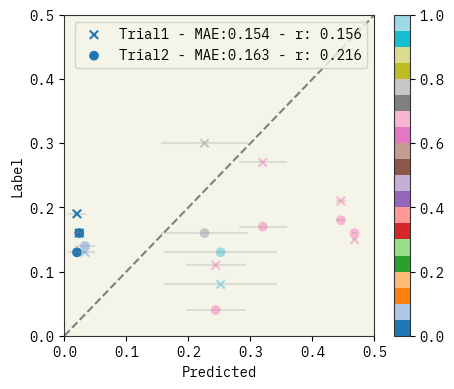

In [349]:
'''
Trial |             f = QY*AUC2                         |
        |  rep1 |   rep2| Predicted/designed |
1.    | 0.19  | 0.13 | 0.02024 +/- 0.01381|
2.    | 0.16  | 0.16 |  0.024 +/- 0.008.     |
3.    | 0.13  | 0.14 | 0.03320 +/- 0.0162 |
4.    | 0.11  | 0.04 |. 0.244 +/- 0.0484     |
5.    | 0.08  | 0.13 | 0.252 +/- 0.09130    |
6     | 0.30  | 0.16 |. 0.226 +/- 0.07          |
7.    | 0.15  | 0.16 |. 0.468 +/- 0.00399   |
8.    | 0.21  | 0.18 | 0.4460 +/- 0.008      |
9     | 0.27  | 0.17. | 0.32 +/- 0.0388         |
'''

t1 = np.array([
    0.19, 0.16, 0.13, 0.11, 0.08, 0.30, 0.15, 0.21, 0.27
])
t2 = np.array([
    0.13, 0.16, 0.14, 0.04, 0.13, 0.16, 0.16, 0.18, 0.17
])
predicted = np.array([
    0.02024, 0.024, 0.03320, 0.244, 0.252, 0.226, 0.468, 0.446, 0.32
])
std = np.array([
    0.01381, 0.008, 0.0162, 0.0484, 0.09130, 0.07, 0.00399, 0.008, 0.0388
])
mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))
corr = lambda a, b: np.corrcoef(a, b)[0, 1]

acq = predicted + 5*std
print(acq)
acq = (acq - acq.min())/(acq.max() - acq.min())
print(acq)

# plot parity plots with t1 and t2 vs predicted. Color by the position in the list
plt.figure()
# select the color palette to maximize color gradient on plt
plt.set_cmap('tab20')
plt.scatter(predicted, t1, c=acq, label=f'Trial1 - MAE:{mae(predicted, t1):.3f} - r: {corr(predicted, t1):.3f}', marker='x')
plt.scatter(predicted, t2, c=acq, label=f'Trial2 - MAE:{mae(predicted, t2):.3f} - r: {corr(predicted, t2):.3f}', marker='o')
plt.errorbar(predicted, t1, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.errorbar(predicted, t2, xerr=std, fmt='none', ecolor='gray', alpha=0.2)
plt.colorbar()
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Label")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()


## Testing prediction

In [96]:
df = pd.read_csv('Data/procedures_new.tsv', sep="\t")
prompts = df['prompt'].tolist()
labels_f = df['obj_f'].to_list()

In [97]:
import numpy as np
indexes = np.arange(len(prompts))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

In [98]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7,
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
else:
    inv_system_message = ""

for i in train_indexes:
  if labels_f[i] >= 0:
    asktell.tell(prompts[i], labels_f[i])

In [ ]:
yhat=[]
y=[]
for i in test_indexes:
  yhat.append(asktell.predict(prompts[i] , system_message=""))
  y.append(labels_f[i]) 

In [ ]:
for i in test_indexes:
  print(f"{prompts[i]} => {labels_f[i]}")

# [f"{i.mean():.2f}" for i in yhat], y

In [ ]:
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
  n+=1
  mae = abs(ihat.mean()-i)
  print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
  sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
yhat_mean = [ihat.mean() for ihat in yhat]
y_plot    = np.array(y)[np.where(np.array(yhat_mean) <= 1)]
yhat_plot = np.array(yhat_mean)[np.where(np.array(yhat_mean) <= 1)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(yhat_mean) <= 1)]
plt.figure(figsize=(6, 4))
plt.xlabel('Experimental outcome')
plt.ylabel('Predicted outcome')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('LLM prediction: f = QY * AUC2')
plt.plot((0,0.4), (0,0.4), '--')
plt.text(0.75, 0.90, f"RMSE: {rmse(y_plot, yhat_plot):.2f}", fontsize=12, transform=plt.gca().transAxes)
plt.show()

## Bayesian optimization

In [10]:
proc_list = pd.read_csv('Data/procedures.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pool_{pool_type}.txt", sep=';')
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list['prompt'].to_list())


In [ ]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

In [ ]:
max(labels_f)

In [ ]:
selected = asktell.ask(pool, aq_fxn="expected_improvement", k=5, inv_filter=15, aug_random_filter=1, inv_system_message=inv_system_message, system_message=system_message)
i = 0
for prompt, p in zip(selected[0], asktell.predict(selected[0], system_message=system_message)):
    print(f"{prompt} => {p.mean():.4f} +/- {p.std():.4f}\n")
    # print(f"{i+1}: {prompt}")
    i+=1


In [ ]:
i=0
for prompt in selected[0]:
    print(f"{i+1}: {prompt}\n")
    i+=1

## New exp suggestion

In [12]:
proc_list = pd.read_csv('Data/procedures.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pool_{pool_type}.txt", sep=';')
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list['prompt'].to_list())


In [13]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

Loaded system message
Loaded inv system message
Pool of 2592 items with 0 selected
Pool of 2592 items with 4 selected


In [14]:
max(labels_f)

0.6231982438593943

In [15]:
propts = []
preds_mean = []
preds_std = []

for p in pool:
  propts.append(p)
  pred = asktell.predict(p, system_message=system_message)
  preds_mean.append(pred.mean())
  preds_std.append(pred.std())

predicted_pool = pd.DataFrame({
  'prompt': propts, 
  'pred_mean': preds_mean,
  'pred_std': preds_std
  })

In [16]:
predicted_pool.sort_values(by='pred_mean', ascending=True, inplace=True)
predicted_pool.to_csv(f'Data/predicted_pool_{pool_type}.txt', sep=';', index=False)
predicted_pool

,prompt,pred_mean,pred_std
19,Stock nanoplatelets have dimensions 33.654 nm ...,0.0400,0.018974
675,Stock nanoplatelets have dimensions 30.594 nm ...,0.0419,0.018095
893,Stock nanoplatelets have dimensions 30.594 nm ...,0.0423,0.021810
26,Stock nanoplatelets have dimensions 33.654 nm ...,0.0440,0.026533
21,Stock nanoplatelets have dimensions 33.654 nm ...,0.0520,0.024000
...,...,...,...
1133,Stock nanoplatelets have dimensions 33.654 nm ...,520.1240,259.752000
2257,Stock nanoplatelets have dimensions 30.594 nm ...,520.1320,259.736000
816,Stock nanoplatelets have dimensions 33.654 nm ...,520.2240,259.552000
1132,Stock nanoplatelets have dimensions 33.654 nm ...,650.0000,0.140257


In [354]:
filtered_pool = predicted_pool[predicted_pool['pred_mean'] < 1.0]
filtered_pool = filtered_pool[filtered_pool['pred_std'] < 0.1]

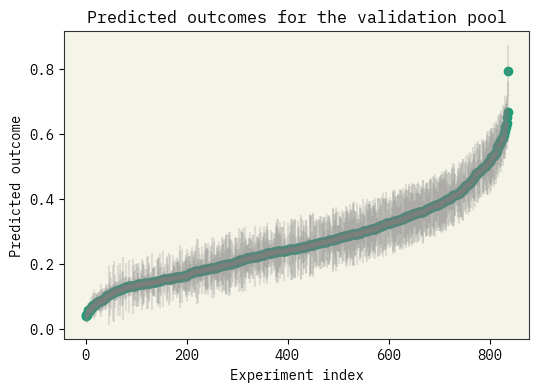

In [355]:
# plot filtered+pool means using pred_std as error
plt.figure(figsize=(6, 4))
plt.errorbar(range(len(filtered_pool)), filtered_pool['pred_mean'],yerr=filtered_pool['pred_std'], fmt='.', alpha=0.2, color='gray')
plt.scatter(range(len(filtered_pool)), filtered_pool['pred_mean'], label='Filtered pool')
plt.xlabel('Experiment index')
plt.ylabel('Predicted outcome')
plt.title('Predicted outcomes for the validation pool')
plt.show()

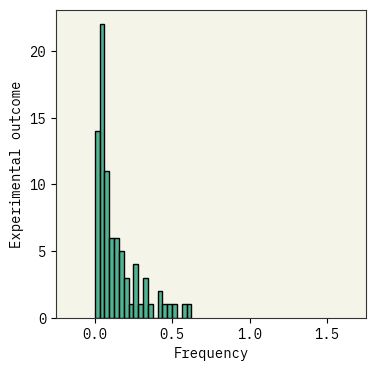

In [44]:
# make a histogram of labels_f using sns with the frequency in the axis x
# rotate the previous histogram so that the experimental outcome is in the y-axis. Also limit the range to [0,1]
plt.figure(figsize=(4, 4))
sns.histplot(labels_f, bins=20)
plt.ylabel('Experimental outcome')
plt.xlabel('Frequency')
# plt.title('Histogram of the experimental outcomes')
plt.xlim(-0.25, 1.75)
plt.show()

In [19]:
for l in [2,4,23, 950,953,947, 965,964,962]:
# for l in range(900, 950):
  print(f''' ------------ [index: {l}] ------------
  prompt: {filtered_pool.iloc[l]['prompt']}
  prediction: {filtered_pool.iloc[l]['pred_mean']} +/- {filtered_pool.iloc[l]['pred_std']}
  ''')

 ------------ [index: 2] ------------
  prompt: Stock nanoplatelets have dimensions 30.594 nm by 8.897 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.500 mL nanoplatelets stock is diluted 7x by hexanes using 3.500 mL for each trial of doping. Silver acetate solution of 0.00600 M is made with 14.000 mg of silver acetate in 9.985 mL of MeOH and 3.994 mL of water. 2.000 % Ag doping requires 4.694 uL of silver doping solution, respectively. The reaction was performed at 1000 rpm for 10.0 minutes at 25.000 oC. Fluorescence of each doped sample was collected as a 30x dilution with hexanes.
  prediction: 0.0423 +/- 0.021809630900132174
  
 ------------ [index: 4] ------------
  prompt: Stock nanoplatelets have dimensions 33.654 nm by 6.926 nm and the optical density of 100x hexanes dilution of stock is 0.150% recorded at 512 nm. 0.250 mL nanoplatelets stock is diluted 7x by hexanes using 1.750 mL for each trial of doping. Silver acetate solution o

IndexError: single positional indexer is out-of-bounds